## Setup

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# to load saved model from google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
torch.manual_seed(0)

Mounted at /gdrive
/gdrive


To visualize tensor data

In [2]:
def show_tensor_image(image_tensor,num_images=16,size=(3,64,64),nrow=3):
  '''
  Function for visualizing images: Given a tensor of images, number of images,
  size per image, and images per row, plots and prints the images in an uniform grid.
  '''

  image_tensor=(image_tensor+1)/2
  img_unflat=image_tensor.detach().cpu()
  img_grids=make_grid(img_unflat[:num_images],nrow=nrow)
  plt.imshow(img_grids.permute(1,2,0).squeeze())
  plt.show()

## Generator and Noise

In [3]:
class Generator(nn.Module):
  '''
  Generator Class
  Values:
      z_dim: the dimension of the noise vector, a scalar
      im_chan: the number of channels of the output image, a scalar
            (CelebA is rgb, so 3 is your default)
      hidden_dim: the inner dimension, a scalar
  '''

  def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    # Build the neural network
    self.gen = nn.Sequential(
      self.make_gen_block(z_dim, hidden_dim * 8),
      self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
      self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
      self.make_gen_block(hidden_dim * 2, hidden_dim),
      self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
    )

  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    '''
    Function to return a sequence of operations corresponding to a generator block of DCGAN;
    a transposed convolution, a batchnorm (except in the final layer), and an activation.
    Parameters:
      input_channels: how many channels the input feature representation has
      output_channels: how many channels the output feature representation should have
      kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
      stride: the stride of the convolution
      final_layer: a boolean, true if it is the final layer and false otherwise 
          (affects activation and batchnorm)
    '''
    if not final_layer:
      return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True),
        )
    else:
      return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.Tanh(),
        )

  def forward(self, noise):
    '''
    Function for completing a forward pass of the generator: Given a noise tensor, 
    returns generated images.
    Parameters:
    noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    x = noise.view(len(noise), self.z_dim, 1, 1)
    return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
  '''
  Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
  creates a tensor of that shape filled with random numbers from the normal distribution.
  Parameters:
  n_samples: the number of samples to generate, a scalar
  z_dim: the dimension of the noise vector, a scalar
  device: the device type
  '''
  return torch.randn(n_samples, z_dim, device=device)

### Classifier

In [4]:
class Classifier(nn.Module):
  '''
  Classifier Class
  Values:
    im_chan: the number of channels of the output image, a scalar
      (CelebA is rgb, so 3 is your default)
    n_classes: the total number of classes in the dataset, an integer scalar
    hidden_dim: the inner dimension, a scalar
  '''

  def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
    super(Classifier, self).__init__()
    self.classifier = nn.Sequential(
      self.make_classifier_block(im_chan, hidden_dim),
      self.make_classifier_block(hidden_dim, hidden_dim * 2),
      self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
      self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
    )

  def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    '''
    Function to return a sequence of operations corresponding to a classifier block; 
    a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
    Parameters:
    input_channels: how many channels the input feature representation has
    output_channels: how many channels the output feature representation should have
    kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
    stride: the stride of the convolution
    final_layer: a boolean, true if it is the final layer and false otherwise 
              (affects activation and batchnorm)
    '''
    if not final_layer:
      return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2, inplace=True),
      )
    else:
      return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      )

  def forward(self, image):
    '''
    Function for completing a forward pass of the classifier: Given an image tensor, 
    returns an n_classes-dimension tensor representing classes.
    Parameters:
      image: a flattened image tensor with im_chan channels
    '''
    class_pred = self.classifier(image)
    return class_pred.view(len(class_pred), -1)

## Specifying Parameters

In [5]:
z_dim = 64
batch_size = 128
device = 'cuda'

## Loading the Pre-trained Models

In [7]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/gdrive/My Drive/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("/gdrive/My Drive/pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Feature Correlation

In [8]:
# First you generate a bunch of fake images with the generator
n_images = 256
fake_image_history = []
classification_history = []
grad_steps = 30 # How many gradient steps to take
skip = 2 # How many gradient steps to skip in the visualization

In [9]:
feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

In [10]:
n_features = len(feature_names)
# Set the target feature
target_feature = "Male"
target_indices = feature_names.index(target_feature)
noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

In [11]:
# Additive direction (more of a feature)
for i in range(grad_steps):
  opt.zero_grad()
  fake = gen(new_noise)
  fake_image_history += [fake]
  classifications = classifier(fake)
  classification_history += [classifications.cpu().detach()]
  fake_classes = classifications[:, target_indices].mean()
  fake_classes.backward()
  new_noise.data += new_noise.grad / grad_steps

In [12]:
# Subtractive direction (less of a feature)
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
  opt.zero_grad()
  fake = gen(new_noise)
  fake_image_history += [fake]
  classifications = classifier(fake)
  classification_history += [classifications.cpu().detach()]
  fake_classes = classifications[:, target_indices].mean()
  fake_classes.backward()
  new_noise.data -= new_noise.grad / grad_steps

In [13]:
classification_history=torch.stack(classification_history)

In [14]:
print(classification_history.shape)
print(starting_classifications[None, :, :].shape)

torch.Size([60, 256, 40])
torch.Size([1, 256, 40])


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

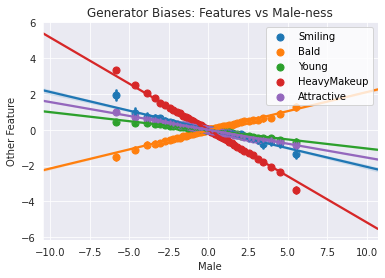

In [15]:
import seaborn as sns
# Set the other features
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive"]
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()
for other_feature in other_features:
  other_indices = feature_names.index(other_feature)
  with sns.axes_style("darkgrid"):
    sns.regplot(
      classification_changes[:, :, target_indices].reshape(-1), 
      classification_changes[:, :, other_indices].reshape(-1), 
      fit_reg=True,
      truncate=True,
      ci=99,
      x_ci=99,
      x_bins=len(classification_history),
      label=other_feature
    )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

In [16]:
def get_top_covariances(classification_changes, target_index, top_n=10):
    '''
    Function for getting the top n covariances: Given a list of classification changes
    and the index of the target feature, returns (1) a list or tensor (numpy or torch) of the indices
    corresponding to the n most covarying factors in terms of absolute covariance
    and (2) a list or tensor (numpy or torch) of the degrees to which they covary.
    Parameters:
        classification_changes: relative changes in classifications of each generated image 
          resulting from optimizing the target feature (see above for a visualization)
        target_index: the index of the target feature, a scalar
        top_n: the top most number of elements to return, default is 10
    '''
    flattened_changes = classification_changes.reshape(-1, classification_changes.shape[-1]).T
    covariances = np.cov(flattened_changes)
    relevant_indices = torch.topk(torch.Tensor(np.abs(covariances[target_index])), top_n + 1)[1][1:].numpy()
    highest_covariances = covariances[target_index, relevant_indices]
    return relevant_indices, highest_covariances

In [22]:
relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print('relevant indices are \n',relevant_indices)
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")

relevant indices are 
 [36 18 24 30  0 22 16 38  9 34]
WearingLipstick  -2.952764
HeavyMakeup  -2.705969
NoBeard  -2.559940
Sideburn  2.049616
5oClockShadow  2.006886
Mustache  1.998510
Goatee  1.859582
WearingNecktie  1.583758
BlondHair  -1.241764
WearingEarrings  -1.207917
